### Imports & Constants

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ROOT import TH3F, TFile
from scipy import stats
from IPython.display import clear_output

Welcome to JupyROOT 6.16/00


In [2]:
map_dir = "maps/"
input_dir = "input/"
output_dir = "output/"

In [3]:
# Minimum track length in the TPC
clean_query = "pfp_length_traj>25"
y_min = -116.5
xlim_query = "(track_startx>1 & track_startx<265) & (track_endx>1 & track_endx<265)"
zlim_query = "(track_startz>0 & track_startz<1036.8) & (track_endz>0 & track_endz<1036.8)"
ylim_query = "(track_starty>@y_min & track_starty<118) & (track_endy>@y_min & track_endy<118)"
117.5
# Amount of events per sample to include
num_events = 6200
# Plot label
ub_tag = "MicroBooNE, In Progress"

### Load the ROOT SCE maps

In [4]:
map_cv = TFile(map_dir + 'SCEcalib_Cosmics_CentralValue.root')
map_up = TFile(map_dir + 'SCEcalib_Cosmics_UpOneSigma.root')
map_down = TFile(map_dir + 'SCEcalib_Cosmics_DownOneSigma.root')
maps_joel = TFile(map_dir + 'VariedForwardMapsVolumeSmoothed.root')

In [5]:
joel = False
x_corr_arr = []
y_corr_arr = []
z_corr_arr = []

if joel == True:

    for i in range(100):
        h3x = maps_joel.Get("combined_fwd_dX_" + i)
        h3y = maps_joel.Get("combined_fwd_dY_" + i)
        h3z = maps_joel.Get("combined_fwd_dZ_" + i)
        x_corr_arr.append(h3x)
        y_corr_arr.append(h3y)
        z_corr_arr.append(h3z)
else:
    for map_sce in [map_cv, map_up, map_down]:
        h3x = map_sce.Get("Reco_Displacement_X")
        h3y = map_sce.Get("Reco_Displacement_Y")
        h3z = map_sce.Get("Reco_Displacement_Z")
        x_corr_arr.append(h3x)
        y_corr_arr.append(h3y)
        z_corr_arr.append(h3z)

### Load the ROOT trees

In [6]:
main_tree_name = 'cosmicstudies'
cols = ['event', 
        'track_startx', 'track_starty', 'track_startz', 
        'track_endx', 'track_endy', 'track_endz']

In [7]:
file_name_data1 = './input/extunbiased_run1_temp.root'
data_file = uproot.open(file_name_data1)[main_tree_name]
data_df = data_file['PFParticles'].pandas.df(cols)
data_df['counter'] = (data_df['event'] != data_df['event'].shift()).cumsum()
data_df = data_df.query('counter<@num_events')
data_lab = 'Cosmic Data (Run 1)'
data_n = len(data_df)
print("%s \tTracks: %d" % (data_lab, data_n))

Cosmic Data (Run 1) 	Tracks: 117147


In [8]:
file_name_mc_nosce = './input/corsika_p_nosce_6k.root'
nosce_file = uproot.open(file_name_mc_nosce)[main_tree_name]
nosce_df = nosce_file['PFParticles'].pandas.df(cols)
nosce_df['counter'] = (nosce_df['event'] != nosce_df['event'].shift()).cumsum()
nosce_df = nosce_df.query('counter<@num_events')
nosce_lab = 'CORSIKA, without space charge'
nosce_n = len(nosce_df)
nosce_s = 1  #nosce_n/data_n
print("%s \tTracks: %d \tData/MC: {0:0.2f}".format(nosce_n/data_n) % (nosce_lab, nosce_n))

CORSIKA, without space charge 	Tracks: 111093 	Data/MC: 0.95


In [9]:
file_name_mc_ddsce = './input/corsika_p_ddsce_8k.root'
ddsce_file         = uproot.open(file_name_mc_ddsce)[main_tree_name]
ddsce_df           = ddsce_file['PFParticles'].pandas.df(cols)
ddsce_df['counter'] = (ddsce_df['event'] != ddsce_df['event'].shift()).cumsum()
ddsce_df = ddsce_df.query('counter<@num_events')
ddsce_lab = 'CORSIKA, data-driven space charge'
ddsce_n = len(ddsce_df)
ddsce_s = 1  #nosce_n/data_n
print("%s \tTracks: %d \tData/MC: {0:0.2f}".format(ddsce_n/data_n) % (ddsce_lab, ddsce_n))

CORSIKA, data-driven space charge 	Tracks: 112260 	Data/MC: 0.96


### Functions

In [10]:
def cosmic_angles(mom_x, mom_y, mom_z, df_out=True):
    mask_flip_dir = (mom_y > 0) * 2 - 1
    mom_x, mom_y, mom_z = mask_flip_dir * mom_x, mask_flip_dir * mom_y, mask_flip_dir * mom_z

    theta_cosmic = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_z)), mom_y)
    phi_cosmic = np.arctan2(mom_x, mom_z)
    if df_out:
        return pd.DataFrame({
            'zenith': theta_cosmic,
            'azimuth': phi_cosmic
        })[['zenith', 'azimuth']]
    else:
        return np.array([theta_cosmic, phi_cosmic])

In [11]:
def straight_length(x_s, y_s, z_s, x_e, y_e, z_e):
    return np.sqrt((x_s - x_e)**2 + (y_s - y_e)**2 + (z_s - z_e)**2)

In [12]:
def cosmic_angles_start_end(x_s, y_s, z_s, x_e, y_e, z_e, df_out=True):
    return cosmic_angles(x_s - x_e, y_s - y_e, z_s - z_e, df_out)

In [13]:
def histHelper(N, x_min, x_max, data):
    edges = np.linspace(x_min, x_max, N + 1)
    edges_mid = [edges[i] + (edges[i + 1] - edges[i]) / 2 for i in range(N)]
    bins = [np.histogram(data_i, bins=edges)[0] for data_i in data]
    max_val = [max(x) for x in bins]
    err = np.sqrt(bins)
    return edges, edges_mid, bins, err, max_val

In [14]:
def chisqrr(obs, exp):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp[i])**2)/(exp[i]+obs[i])
    return chisqr

### Data Manipulation

In [15]:
for df in [data_df, nosce_df, ddsce_df]:
    cols = ['track_startx', 'track_starty', 'track_startz', 'track_endx', 'track_endy', 'track_endz']
    df[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df[cols].T.values)
    df['pfp_length_traj'] = straight_length(*df[cols].T.values)

In [16]:
nosce_df.keys()

Index(['event', 'track_startx', 'track_starty', 'track_startz', 'track_endx',
       'track_endy', 'track_endz', 'counter', 'pfp_zenith_traj',
       'pfp_azimuth_traj', 'pfp_length_traj'],
      dtype='object')

### Plots

In [17]:
track_zenith = {
    "name": 'pfp_zenith_traj',
    "bins": 60,
    "x_min": 0,
    "x_max": np.pi/2,
    "x_label": r"Zenith angle of reconstructed track [rad]",
    "x_ticks": [0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2],
    "x_labels": [r'$0$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi$/2'],
    "title": 'Zenith Angle'
}

track_azimuth = {
    "name": 'pfp_azimuth_traj',
    "bins": 72,
    "x_min": -np.pi,
    "x_max": np.pi,
    "x_label": r"Azimuthal angle of reconstructed track [rad]",
    "x_ticks": [-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],
    "x_labels": [r"$-\pi$", r"$-3\pi/4$", r"$-\pi/2$", r"$-\pi/4$", "0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"],
    "title": 'Azimuth Angle'
}

track_length = {
    "name": "pfp_length_traj",
    "bins": 70,
    "x_min": 25,
    "x_max": 375,
    "x_label": r"Track length [cm]",
    "title": "Track Length"
}

track_starty = {
    "name": 'track_starty',
    "bins": 50,
    "x_min": -120,
    "x_max": 120,
    "x_label": r"Track start y [cm]",
    "title": "Track Start y"
}

track_endy = {
    "name": 'track_endy',
    "bins": 50,
    "x_min": -115,
    "x_max": 115,
    "x_label": r"Track end y [cm]",
    "title": "Track End y"
}

list_plot = [track_zenith, track_azimuth, track_length]#, track_starty, track_endy]

pfp_zenith_traj
CORSIKA, without space charge 	 1.0961038064607222e-10 	 4.138620950374457 	 0.041915303315624895
CORSIKA, data-driven space charge 	 8.916359513114777e-08 	 3.0018298537991606 	 0.08317053151123902
pfp_azimuth_traj
CORSIKA, without space charge 	 0.4349787691275042 	 1.904882653454714 	 0.1675328114960435
CORSIKA, data-driven space charge 	 0.1919341144823261 	 1.667638204982849 	 0.196575176269581
pfp_length_traj
CORSIKA, without space charge 	 5.095441639385142e-132 	 19.721800994425628 	 8.957366158597421e-06
CORSIKA, data-driven space charge 	 1.8702043455188573e-06 	 2.0056704987150633 	 0.1567119895903915


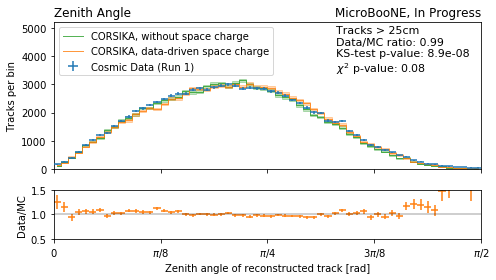

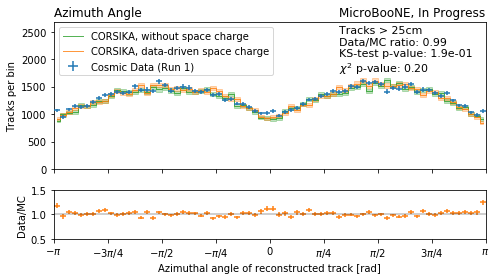

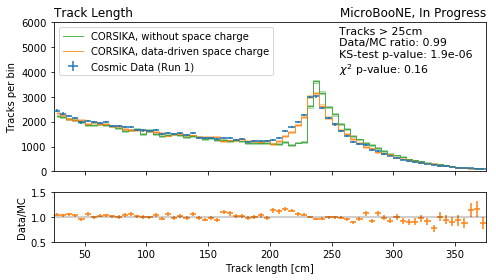

In [18]:
# The default comparison of nosce with ddsce and data

mc_alpha = [0.8, 0.8]
mc_color = ['C2', 'C1']
mc_ratio = [len(nosce_df.query(clean_query))/len(data_df.query(clean_query)),
            len(ddsce_df.query(clean_query))/len(data_df.query(clean_query))
           ]
labs = [nosce_lab, ddsce_lab, data_lab]
data_list = [nosce_df, ddsce_df, data_df]
mc_def = 1

for s in list_plot:
    fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(7,4), gridspec_kw = {'height_ratios':[3, 1]})
    data = [df.query(clean_query)[s["name"]] for df in data_list]
    edges, edges_mid, bins, err, max_y = histHelper(s["bins"], s["x_min"], s["x_max"], data) #, weights=weights)
    
    print(s["name"])
    # Chi2 and KS test
    ks       = [stats.ks_2samp(df.query(clean_query)[s["name"]], data_df.query(clean_query)[s["name"]]) for df in [nosce_df, ddsce_df]]
    chi2     = [chisqrr(bins[-1], b_exp)/s["bins"] for b_exp in bins]
    chi2pval = [stats.distributions.chi2.sf(chi2_this,1) for chi2_this in chi2]
    for k,v,v2,v3 in zip(labs,ks,chi2,chi2pval):
        print(k,'\t',v[1], '\t', v2, '\t', v3)
        

    ax[0].errorbar(edges_mid, bins[-1], yerr=err[-1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
                   zorder=3, label=data_lab)
    next(ax[0]._get_lines.prop_cycler)
    
    for i,(bins_i, err_i, lab_i, max_i, alpha_i, c_i) in enumerate(zip(bins,err,labs, max_y, mc_alpha, mc_color)):
        if alpha_i>0:
            ax[0].step(edges_mid,bins_i,lw=1, label=lab_i, where='mid', alpha=alpha_i, color=c_i)
            ax[0].fill_between(edges_mid, (bins_i - err_i), (bins_i + err_i), alpha=0.3, step='mid', color=c_i)
        
    ax[0].set_ylim(0,max(max_y)*1.65)
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_xlim(s["x_min"],s["x_max"])
    ax[0].legend(loc = "upper left")
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"] )
    
    ratio = bins[-1]/(bins[mc_def])
    ratio_err = np.sqrt(1/bins[-1]+1/(bins[mc_def]))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color=mc_color[mc_def])
    
    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    text_x = s["x_min"]+(s["x_max"]-s["x_min"])*0.66
    ax[0].set_title(ub_tag, loc='right')
    ax[0].set_title(s['title'], loc='left')
    ax[0].text(text_x, ax[0].get_ylim()[1]*0.65, 'Tracks > 25cm\n'+"Data/MC ratio: {0:.2f}\nKS-test p-value: {1:.1e}\n".format(mc_ratio[mc_def], ks[mc_def][1])+r"$\chi^2$ p-value: {0:.2f}".format(chi2pval[mc_def]), fontsize=11)
    
    fig.tight_layout()
    fig.savefig(output_dir+s["name"]+"_25cm.pdf")

### Mike's 3 maps comparison

In [19]:
values = nosce_df.query(xlim_query).query(zlim_query).query(ylim_query)[['track_startx', 'track_starty', 'track_startz', 
                   'track_endx', 'track_endy', 'track_endz']].values.copy()
corrected = [values.copy() for m in x_corr_arr]

values.T[1]=values.T[1]/(118/116.0)
values.T[4]=values.T[4]/(118/116.5)
values.T[2]=abs(values.T[2])/(1036.8/1031.8)
values.T[5]=abs(values.T[5])/(1036.8/1031.8)

In [20]:
#for x in [values.T[0].min(), values.T[0].max()]:
#    for y in [values.T[1].min(), values.T[1].max()]:
#        for z in [values.T[2].min(), values.T[2].max()]:
#            print(x,y,z)
#            print(x_corr_arr[0].Interpolate(x, y, z))

In [21]:
n_tracks = len(values)

for index in range(n_tracks):
    if index%(1000)==0:
        clear_output(wait=True)
        print("progress:\t{0:.0f}%".format(index/n_tracks*100))
        
    val = values[index]
    for out, x_corr, y_corr, z_corr in zip(corrected, x_corr_arr, y_corr_arr, z_corr_arr):
        out[index][0]-= x_corr.Interpolate(val[0], val[1], val[2])
        out[index][1]-= y_corr.Interpolate(val[0], val[1], val[2])
        out[index][2]-= z_corr.Interpolate(val[0], val[1], val[2])
        out[index][3]-= x_corr.Interpolate(val[3], val[4], val[5])
        out[index][4]-= y_corr.Interpolate(val[3], val[4], val[5])
        out[index][5]-= y_corr.Interpolate(val[3], val[4], val[5])
print("done")

progress:	99%
done


In [22]:
for m in corrected:
    m.T[1]=values.T[1]*(118/116.0)
    m.T[4]=m.T[4]*(118/116.5)
    m.T[2]=m.T[2]*(1036.8/1031.8)
    m.T[5]=m.T[5]*(1036.8/1031.8)

In [23]:
cols = ['track_startx', 'track_starty', 'track_startz', 'track_endx', 'track_endy', 'track_endz']
corr_df = [pd.DataFrame(m, columns=cols) for m in corrected]
for df in corr_df:
    cols = ['track_startx', 'track_starty', 'track_startz', 'track_endx', 'track_endy', 'track_endz']
    df[['pfp_zenith_traj','pfp_azimuth_traj']] = cosmic_angles_start_end(*df[cols].T.values)
    df['pfp_length_traj'] = straight_length(*df[cols].T.values)

pfp_zenith_traj
Central Value 	 6.742440353169536e-196 	 2.4981327553182173 	 0.11398136743702918
Sigma Up 	 2.7340353729844694e-193 	 2.4382778540927674 	 0.11840615570292194
Sigma Down 	 1.7005591005251697e-201 	 2.4891487109662265 	 0.11463371439330199
pfp_azimuth_traj
Central Value 	 8.610500248455284e-14 	 2.121793323862178 	 0.14521642145472535
Sigma Up 	 4.821045832461769e-14 	 1.9846593869724944 	 0.1589004094002065
Sigma Down 	 3.0333689633481685e-13 	 2.236836512503674 	 0.1347564279595718
pfp_length_traj
Central Value 	 1.8577855111196302e-200 	 4.907607074344713 	 0.026738659587852025
Sigma Up 	 4.836591706416429e-190 	 4.551953120441673 	 0.03288121846146413
Sigma Down 	 2.5965897991754325e-210 	 5.2707801065834055 	 0.02168629208224236


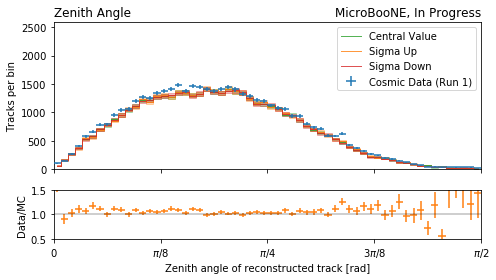

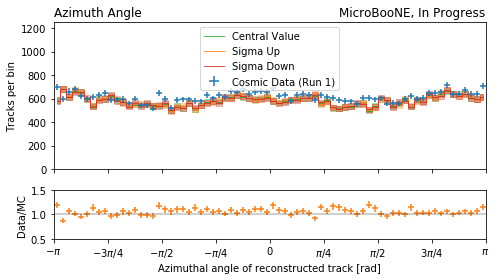

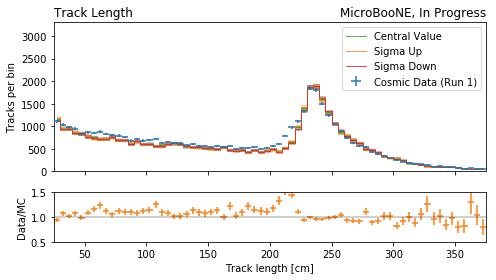

In [24]:
# The mike his maps compared with data

mc_alpha = [0.8, 0.8, 0.8]
mc_color = ['C2', 'C1','C3']
mc_ratio = [len(nosce_df.query(clean_query))/len(data_df.query(clean_query))]
labs = ["Central Value", "Sigma Up", "Sigma Down", data_lab]
data_list = corr_df+[data_df.query(xlim_query).query(zlim_query).query(ylim_query)]
mc_def = 1

for s in list_plot:
    fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(7,4), gridspec_kw = {'height_ratios':[3, 1]})
    data = [df.query(clean_query)[s["name"]] for df in data_list]
    edges, edges_mid, bins, err, max_y = histHelper(s["bins"], s["x_min"], s["x_max"], data) #, weights=weights)
    
    print(s["name"])
    # Chi2 and KS test
    ks       = [stats.ks_2samp(df.query(clean_query)[s["name"]], data_df.query(clean_query)[s["name"]]) for df in corr_df]
    chi2     = [chisqrr(bins[-1], b_exp)/s["bins"] for b_exp in bins]
    chi2pval = [stats.distributions.chi2.sf(chi2_this,1) for chi2_this in chi2]
    for k,v,v2,v3 in zip(labs,ks,chi2,chi2pval):
        print(k,'\t',v[1], '\t', v2, '\t', v3)
        

    ax[0].errorbar(edges_mid, bins[-1], yerr=err[-1], xerr=edges[:-1]-edges_mid, fmt='none', c='C0', 
                   zorder=3, label=data_lab)
    next(ax[0]._get_lines.prop_cycler)
    
    for i,(bins_i, err_i, lab_i, max_i, alpha_i, c_i) in enumerate(zip(bins,err,labs, max_y, mc_alpha, mc_color)):
        if alpha_i>0:
            ax[0].step(edges_mid,bins_i,lw=1, label=lab_i, where='mid', alpha=alpha_i, color=c_i)
            ax[0].fill_between(edges_mid, (bins_i - err_i), (bins_i + err_i), alpha=0.3, step='mid', color=c_i)
        
    ax[0].set_ylim(0,max(max_y)*1.75)
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_xlim(s["x_min"],s["x_max"])
    ax[0].legend(loc = 0)
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"] )
    
    ratio = bins[-1]/(bins[mc_def])
    ratio_err = np.sqrt(1/bins[-1]+1/(bins[mc_def]))*ratio
    ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color=mc_color[mc_def])
    
    ax[1].axhline(y=1,color="k",alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5,1.5)
    text_x = s["x_min"]+(s["x_max"]-s["x_min"])*0.66
    ax[0].set_title(ub_tag, loc='right')
    ax[0].set_title(s['title'], loc='left')
    #ax[0].text(text_x, ax[0].get_ylim()[1]*0.65, 'Tracks > 25cm\n'+"Data/MC ratio: {0:.2f}\nKS-test p-value: {1:.1e}\n".format(mc_ratio[mc_def], ks[mc_def][1])+r"$\chi^2$ p-value: {0:.2f}".format(chi2pval[mc_def]), fontsize=11)
    
    fig.tight_layout()
    fig.savefig(output_dir+s["name"]+"_25cm.pdf")